# General lib imports

In [3]:
import pandas as pd
import numpy as np
from progressbar.bar import ProgressBar
import seaborn as sns

# Code

## Functions

### compute_activation

In [12]:
def compute_activation (X, activation_type):
    '''Defining activation functions
     Takes a nparray or a single value
    # Returns in the same format
    
    For softmax : assuming that X.shape[0]== n_neurons,
        the axis0 of array X is used for computing the mean 
    '''
    X=np.array(X)
    if activation_type == 'relu':
        return np.maximum(X,0)
    elif activation_type == 'sigmoid':
        return 1/(1+np.exp(-X))
    elif activation_type == 'tanh':
        return np.tanh(X)
    elif activation_type == 'linear':
        return X
    elif activation_type == 'softmax':
        exp_x = np.exp(X)
        return exp_x / exp_x.sum(axis=0)

    #raise error if unknown type
    else:
        raise ValueError(f'Unknown activation type {activation_type}. \
Supported types : linear, relu, sigmoid, tanh, softmax')

### compute_activation (version with derivatives option, not used in backprop, kept here in cas of future need)

In [5]:
def compute_activation_old (X, activation_type, derivative=False):
    '''Defining activation functions
     Takes a nparray or a single value
    # Returns in the same format
    
    For softmax : assuming that X.shape[0]== n_neurons,
        the axis0 of array X is used for computing the mean 
    '''
    X=np.array(X)
    if activation_type == 'relu':
        if derivative == False:
            return np.maximum(X,0)
        else:
            return (X > 0).astype(int)
        
    elif activation_type == 'sigmoid':
        if derivative == False:
            return 1 / (1 + np.exp(-X))
        else:
            return np.exp(-X) / np.square(1 + np.exp(-X))
    
    elif activation_type == 'tanh':
        if derivative == False:
            return np.tanh(X)
        else:
            return np.square(1 / np.cosh(X))
            
    elif activation_type == 'linear':
        if derivative == False:
            return X
        else:
            return np.ones(X.shape)
            
    elif activation_type == 'softmax':
        exp_x = np.exp(X)
        sigma_exp_x = exp_x.sum(axis=0)
        if derivative == False: 
            return exp_x / sigma_exp_x
        else:
            return (exp_x * sigma_exp_x - np.square(exp_x)) / np.square(sigma_exp_x)
        
    #raise error if unknown type
    else:
        raise ValueError(f'Unknown activation type {activation_type}. \
Supported types : linear, relu, sigmoid, tanh, softmax')

### compute_activation_derivative

In [6]:
def compute_activation_derivative (layer_output, activation_type):
    '''Computes the derivative of the activation functions,
       depending of the outputs of the output of these functions
           nota : if occures that for each of the 5 basic activations,
           f'(X) can be expressed simply as a function of f(X)
           
           Takes a nparray or a single value
        # Returns in the same format
           '''
    X_output=np.array(layer_output)
    if activation_type == 'relu':
        return (X_output > 0).astype(int)
    if activation_type == 'linear':
        return np.ones(X_output.shape)
    if activation_type == 'sigmoid':
        return X_output - np.square(X_output)
    if activation_type == 'tanh':
        return 1 - np.square(X_output)
    if activation_type == 'softmax':
        return X_output - np.square(X_output)
    
    #raise error if unknown type
    else:
        raise ValueError(f'Unknown activation type {activation_type}. \
Supported types : linear, relu, sigmoid, tanh, softmax')

### compute_metric

In [7]:
def compute_metric (y, y_pred, metric, loss_derivative=False):
    '''Defining loss and metric functions
     Takes nparrays, lists or a single values
     
     ## IF loss_derivative==False:
         output: always scalar
         
     ## IF loss_derivative==True: (True will be ignored for non-loss metrics)
         Computes the partial derivative of the loss function
           with respect to each component of each sample
         output: 2Darray
            n_samples * 1 for binary_crossentropy or single output regression
            n_samples * n_class for categorical_crossentropy
            n_samples * n_features for multifeatures regression)
    '''
        
    #converting DataFrames, lists or lists of lists to nparray
    y = np.array(y)
    y_pred = np.array(y_pred)
        
    #deal with 1D inputs to forge a n_samples * 1 2D-array
    if len(y.shape) == 1:
        y = np.expand_dims(y, axis = 1)
    if len(y_pred.shape) == 1:
        y_pred = np.expand_dims(y_pred, axis = 1)
            
    #raise errors for unconsistant inputs
    if len(y.shape) > 2:
        raise ValueError('y vector dimension too high. Must be 2 max')
    if len(y_pred.shape) > 2:
        raise ValueError('y_pred vector dimension too high. Must be 2 max')
    if y.shape != y_pred.shape:
        raise ValueError(f'unconsistent vectors dimensions during scoring: \
y.shape= {y.shape} and y_pred.shape= {y_pred.shape}')
        
    #compute loss funtions (or derivatives if loss_derivative==True)
    if metric == 'mse':
        if loss_derivative == False:
            return np.square(y-y_pred).mean()
        else:
            return 1 / y.size * 2 * (y_pred - y)
        
    elif metric == 'mae':
        if loss_derivative == False:
            return np.abs(y-y_pred).mean()
        else:
            return 1 / y.size * (y_pred - y) / np.abs(y - y_pred)
        
    elif metric == 'categorical_crossentropy':
        if loss_derivative == False:
            return -1 / y.shape[0] * ((y * np.log(y_pred)).sum())
        else:
            return -1 / y.shape[0] * (y / y_pred)
        
    elif metric == 'binary_crossentropy':
        if y.shape[1]>1:
            raise ValueError('y vector dimension too high. \
Must be 1 max for binary_crossentropy')
        if loss_derivative == False:
            return -(y*np.log(y_pred)+(1-y)*np.log(1-y_pred)).mean()
        else:
            return -1 / y.size * (y / y_pred - (1-y) / (1-y_pred))
        
    # compute other metrics functions
    ## TODO ## accuracy, f1-score, recall, etc..
    else:
        raise ValueError(f'Unknown metric {metric}. Supported types: \
mse, mae, categorical_crossentropy, binary_crossentropy')

## Optimizers

In [8]:
class adam_optimizer():
    def __init__(self, weights, bias, alpha_init=0.001, beta_1=0.9,
             beta_2=0.999, epsilon=1e-8):
        
        self.alpha_init=alpha_init
        self.beta_1=beta_1
        self.beta_2=beta_2
        self.epsilon=epsilon
    
        self.t=0
        #initializing first and second momentum
        self.m_weights = [np.zeros_like(w) for w in weights]
        self.m_bias = [np.zeros_like(b) for b in bias]
        self.v_weights = self.m_weights.copy()
        self.v_bias = self.m_bias.copy()
        
    def get_update(self, gradient_weights, gradient_bias):
        self.t+=1
        alpha=self.alpha_init*np.sqrt(1-self.beta_2**self.t)/(1-self.beta_1**self.t)
                    
        # updating 1st and 2nd momenta
        self.m_weights=[self.beta_1 * m + (1-self.beta_1) * grad\
                   for m, grad in zip(self.m_weights, gradient_weights)]
        self.m_bias=[self.beta_1 * m + (1-self.beta_1) * grad\
                   for m, grad in zip(self.m_bias, gradient_bias)]
        self.v_weights=[self.beta_2 * v + (1-self.beta_2) * grad**2\
                   for v, grad in zip(self.v_weights, gradient_weights)]
        self.v_bias=[self.beta_2 * v + (1-self.beta_2) * grad**2\
                   for v, grad in zip(self.v_bias, gradient_bias)]
        
        #computing the updates
        weights_update = [- alpha * m / (np.sqrt(v) + self.epsilon)\
                                  for m, v in zip( self.m_weights, self.v_weights)]
        bias_update = [- alpha * m / (np.sqrt(v) + self.epsilon)\
                                  for m, v in zip( self.m_bias, self.v_bias)]
        
        return weights_update, bias_update

## Model class

In [1]:
class handmade_nn ():
    '''
    hand-made version of neural network
    so far, the possibilities are :
    
        - layers activation functions :
            'linear', 'relu', 'sigmoid', 'tanh', 'softmax'
        
        - weights initializers : 'ones', 'glorot_uniform'
        - bias initializers : 'zeros', 'ones'
    
        - loss functions :
            'mse', 'mae', 'binary_crossentropy', 'categorical_crossentropy'
    
        - solver :
            SGD without momentum 'sgd', 'adam'
    '''
    def __init__ (self, input_dim=0):
        self.weights=[]
        self.bias=[]
        self.activation_types=[]
        self.input_dim=input_dim
        self.n_layers=0
 
        self.loss_history=[]

    def set_input_dim (self, input_dim):
        self.input_dim = input_dim
        
    def set_loss (self, loss_type):
        self.loss_type = loss_type
        
    def add_dense_layer (self, n_neurons, activation_type, 
                         weights_initializer='glorot_uniform', bias_initializer='zeros'):
        #check if the input_dim is set
        if self.input_dim == 0:
            raise ValueError('input_dim = 0 .\
Use set_input_dim before creating first layer')
            
        #get the size of the input os this layer
        if len(self.bias) == 0:
            previous_dim=self.input_dim
        else:
            previous_dim=(self.bias[-1].shape[0])
            
        #initialize the layer parameters
        if weights_initializer == 'ones':
            self.weights.append(np.ones((n_neurons, previous_dim)))
        elif weights_initializer == 'glorot_uniform':
            limit = np.square(6 / (n_neurons + previous_dim))
            self.weights.append(np.random.uniform(-limit, limit, size = (n_neurons, previous_dim)))
        else:
            raise ValueError(f'Unknown weights initializer {weights_initializer}.\
Supported types : ones, glorot_uniform')
            
        if bias_initializer == 'zeros':
            self.bias.append(np.zeros(n_neurons))
        elif bias_initializer == 'ones':
            self.bias.append(np.ones(n_neurons))
        else:
            raise ValueError(f'Unknown bias initializer {bias_initializer}.\
Supported types : zeros, ones')
            
        self.activation_types.append(activation_type)
        self.n_layers += 1
        
        #test the activation type
        compute_activation(0, activation_type)
        
    def predict (self, X, keep_hidden_layers=False):
        '''input X : list, list of lists, np array, pd DataFrame
               axis 0 = samples
               axis 1 = features
               
           ## IF keep_hidden_layers==False:
           output = y_pred: 2D np-array
               axis 0 = samples
               axis 1 = output features, depending of the size of last layer
               
           ## IF keep_hidden_layers==True:
           outputs = layers_outputs, layers_activation_derivatives
           -output1 = layers_outputs:
               list of 2D np-arrays of outputs of each layer
               len(list)=n_layers+1: 1st element = X itself
                                     last element = y_pred
               axis 0 = samples
               axis 1 = number of neurons of the layer
           -output2 = layers_activation_derivatives:
               list of 2D np-arrays of d_act/d_input of each layer
               len(list)=n_layers
               axis 0 = samples
               axis 1 = number of neurons of the layer
           '''
        #converting DataFrames, lists or lists of lists to nparray
        X = np.array(X)
        
        #deal with 1D inputs to forge a 1 * n_features 2D-array
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis = 0)
            
        #raise errors for unconsistant inputs
        if len(X.shape) > 2:
            raise ValueError('X vector dimension too high. Must be 2 max')
        if X.shape[1] != self.input_dim:
            raise ValueError(f'Unconsistent number of features. \
The network input_dim is {self.input_dim}')
            
        #compute the prediction
        layers_outputs = [X]
        layers_activation_derivatives = []
        for layer_index, activation_type in enumerate(self.activation_types):
            activation_input = np.dot(self.weights[layer_index], X.T)\
                               + np.expand_dims(self.bias[layer_index], axis=1)
            X = compute_activation(activation_input, activation_type).T

            layers_outputs.append(X)
            layers_activation_derivatives.append(\
                compute_activation_derivative(X, activation_type))
                
        if keep_hidden_layers == True:
            return layers_outputs, layers_activation_derivatives
        else:
            return X
    
    def score (self, X, y, metric):
        '''use predict method, then compute_metric function'''
        y_pred=self.predict(X)
        return compute_metric(y, y_pred, metric)
    
    def compute_backpropagation (self, X, y):
        '''This method :
            - executes self.predict(X) WITH keep_hidden_layers
                to keep all intermediate outputs
            - executes compute_metric (y, y_pred, loss) WITH loss_derivative
            - for each layer from last to first : computes loss
              derivatives (aka gradient) with respect to bias and weights
              
            output 1 : gradient with respect to weights 
               (list of 2D arrays 
               len(list) = n_layers
               axis 0 = number of neurons of the layer
               axis 1 = number of neurons of the previous layer (or features in the input)
            output 2 : gradient with respect to bias
               (list of 1D arrays)
               len(list) = n_layers
               axis 0 = number of neurons of the layer
            '''
        delta_weights=[]
        delta_bias=[]
        
        # compute the outputs and the derivatives of each layer
        layers_outputs, layers_activation_derivatives\
                = self.predict(X, keep_hidden_layers = True)
        # compute d_loss/d_ypred
        dloss_doutput = compute_metric (y, 
                                        layers_outputs[-1], 
                                        self.loss_type, 
                                        loss_derivative = True)
        for layer_index in range(self.n_layers-1, -1, -1):
            # compute d_loss/d_input of the layer
            dloss_dinput = dloss_doutput * layers_activation_derivatives[layer_index]
            
            # compute gradient with respect to weights and bias
            delta_weights.append(np.dot(dloss_dinput.T, layers_outputs[layer_index]))
            delta_bias.append(np.sum(dloss_dinput, axis=0))
            
            # update dloss_doutput for next propagation
            if layer_index > 0:
                dloss_doutput = np.dot (dloss_dinput, self.weights[layer_index])
        
        delta_weights.reverse()
        delta_bias.reverse()
                
        return delta_weights, delta_bias
            
    
    def fit (self, X, y, loss_type=None, learning_rate=0.01,
             batch_size=1, n_epochs=10, verbose=1,
             optimizer_type='sgd',
             alpha_init=0.001, beta_1=0.9,
             beta_2=0.999, epsilon=1e-8):
        '''input X : 2D array or pd DataFrame
                axis 0 = samples
                axis 1 = features
        '''
        if loss_type:
            self.loss_type=loss_type
        
        if optimizer_type == 'adam':
            optimizer = adam_optimizer (self.weights, self.bias, 
                                        alpha_init=alpha_init, beta_1=beta_1,
                                        beta_2=beta_2, epsilon=epsilon)
        
        X = np.array(X)
        y = np.array(y)
        n_samples = X.shape[0]
        n_minibatches_per_epoch = int((n_samples-1) / batch_size) + 1
        
        loss=self.score(X, y, self.loss_type)
        if self.loss_history == []:
            self.loss_history.append(loss)
        if verbose>0:
            print(f'initial loss: {loss}')
        
        for epoch_index in range (n_epochs):
            if verbose>1:
                print(f'beginning epoch n°{epoch_index + 1}')
                
            #progress_batches = ProgressBar()
            #for mini_batch_index in progress_batches(range(n_minibatches_per_epoch)):
            for mini_batch_index in range(n_minibatches_per_epoch):
                gradient_weights, gradient_bias\
                    = self.compute_backpropagation(X[mini_batch_index * batch_size :\
                                                     (mini_batch_index +1) * batch_size],
                                                   y[mini_batch_index * batch_size :\
                                                     (mini_batch_index +1) * batch_size])
                if optimizer_type == 'sgd':
                    #compute the update directly
                    weights_update = [-learning_rate * grad for grad in gradient_weights]
                    bias_update = [-learning_rate * grad for grad in gradient_bias]
               
                elif optimizer_type == 'adam':
                    #compute the update with the optimizer
                    weights_update, bias_update = optimizer.get_update(gradient_weights, gradient_bias)
                
                else:
                    raise ValueError(f'unsupported optimizer type {optimizer}') 
                    
                # updating weights and bias
                self.weights = [w + w_update  for w, w_update in zip(self.weights, weights_update)]
                self.bias = [b + b_update for b, b_update in zip(self.bias, bias_update)]
            
            loss=self.score(X, y, self.loss_type)
            self.loss_history.append(loss)
            if verbose>1:
                
                print(f'end of epoch n°{epoch_index + 1}. loss: {loss}')
                
        if verbose==1:
            print(f'final loss: {loss}')
            
    def plot_loss_history(self):
        '''Make a simple plot loss versus epochs'''
        graph=sns.lineplot(x=range(len(self.loss_history)),y=self.loss_history)
        graph.set(xlabel="epochs", ylabel = "loss")
        

# Tests

In [14]:
if __name__ == "__main__":
    #test all the features of the handmade_nn class
    from unittest import TestCase

## compute_activation function tests

In [8]:
    #---------------------------------------------------------------------------
    ## tests for function compute_activation
    #---------------------------------------------------------------------------

    assert (compute_activation(np.array([[-1,0], [0, 1], [1, 3]]),
                               'relu') ==\
            np.array([[0,0], [0, 1], [1, 3]]))\
            .all(), "uncorrect relu function behaviour"

    #---------------------------------------------------------------------------
    assert (compute_activation(np.array([[-1,0], [0, 1], [1, 3]]),
                               'linear') ==\
            np.array([[-1,0], [0, 1], [1, 3]]))\
            .all(), "uncorrect linear function behaviour"

    #---------------------------------------------------------------------------
    assert (np.round(compute_activation(np.array([[-1,0], [0, 1], [1, 3]]),
                                        'sigmoid'), decimals= 8) ==\
            np.array([[0.26894142, 0.5       ],
                      [0.5       , 0.73105858],
                      [0.73105858, 0.95257413]]))\
            .all(), "uncorrect sigmoid function behaviour"

    #---------------------------------------------------------------------------
    assert (np.round(compute_activation(np.array([[-1,0], [0, 1], [1, 3]]),
                                        'tanh'), decimals= 8) ==\
            np.array([[-0.76159416,  0.        ],
                      [ 0.        ,  0.76159416],
                      [ 0.76159416,  0.99505475]]))\
            .all(), "uncorrect tanh function behaviour"

    #---------------------------------------------------------------------------
    assert (np.round(compute_activation(np.array([[-1,0], [0, 1], [1, 3]]),
                                        'softmax'), decimals= 8) ==\
            np.array([[0.09003057, 0.04201007],
                      [0.24472847, 0.1141952 ],
                      [0.66524096, 0.84379473]]))\
            .all(), "uncorrect softmax function behaviour"

    #---------------------------------------------------------------------------
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        compute_activation(0,'typo_error')
    assert 'Unknown activation type' in str(context.exception),\
        "no or wrong Exception raised when inputing an unknown activation_type\
         while calling compute_activation"

## compute_activation_derivative function tests

In [9]:
    #---------------------------------------------------------------------------
    ## tests for function compute_activation_derivative
    #---------------------------------------------------------------------------

    assert (compute_activation_derivative(np.array([[0,0], [0, 1], [1, 3]]),
                                          'relu') ==\
            np.array([[0,0], [0, 1], [1, 1]]))\
            .all(), "uncorrect relu function behaviour"

    #---------------------------------------------------------------------------
    assert (compute_activation_derivative(np.array([[-1,0], [0, 1], [1, 3]]),
                                          'linear') ==\
            np.array([[1,1], [1, 1], [1, 1]]))\
            .all(), "uncorrect linear function behaviour"

    #---------------------------------------------------------------------------
    assert (np.round(compute_activation_derivative\
                     (np.array([[0.26894142, 0.5       ],
                                [0.5       , 0.73105858],
                                [0.73105858, 0.95257413]]),
                      'sigmoid'), decimals= 8) ==\
            np.array([[0.19661193, 0.25      ],
                      [0.25      , 0.19661193],
                      [0.19661193, 0.04517666]]))\
            .all(), "uncorrect sigmoid function behaviour"

    #---------------------------------------------------------------------------
    assert (np.round(compute_activation_derivative\
                     (np.array([[-0.76159416,  0.        ],
                                [ 0.        ,  0.76159416],
                                [ 0.76159416,  0.99505475]]),
                                        'tanh'), decimals= 8) ==\
            np.array([[0.41997434, 1.        ],
                      [1.        , 0.41997434],
                      [0.41997434, 0.00986604]]))\
            .all(), "uncorrect tanh function behaviour"

    #---------------------------------------------------------------------------
    assert (np.round(compute_activation_derivative\
                     (np.array([[0.09003057, 0.04201007],
                                [0.24472847, 0.1141952 ],
                                [0.66524096, 0.84379473]]),
                                        'softmax'), decimals= 8) ==\
            np.array([[0.08192507, 0.04024522],
                      [0.18483645, 0.10115466],
                      [0.22269543, 0.13180518]]))\
            .all(), "uncorrect softmax function behaviour"

    #---------------------------------------------------------------------------
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        compute_activation_derivative(0,'typo_error')
    assert 'Unknown activation type' in str(context.exception),\
        "no or wrong Exception raised when inputing an unknown activation_type\
         while calling compute_activation_derivative"

## add_dense_layer method tests

In [10]:
    #---------------------------------------------------------------------------
    ## tests for method add_dense_layer
    #---------------------------------------------------------------------------

    my_nn=handmade_nn()
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        my_nn.add_dense_layer(5,'relu')
    assert 'Use set_input_dim before creating first layer'\
           in str(context.exception),\
        "no or wrong Exception raised when adding first layer\
         to a network without setting input_dim"

    #---------------------------------------------------------------------------
    my_nn=handmade_nn(5)
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        my_nn.add_dense_layer(10,'typo_error')
    assert 'Unknown activation type' in str(context.exception),\
        "no or wrong Exception raised when inputing\
         an unknown activation_type while adding layer"

## predict method tests without hidden_layers

In [11]:
    #---------------------------------------------------------------------------
    ## tests for method predict - normal mode (without intermediate states) ####
    #---------------------------------------------------------------------------

    my_nn=handmade_nn(5)# Empty neural network : just a pass-through for 5-values inputs

    assert my_nn.predict([2,3,2,3,4]).shape == (1,5),\
        "list not supported as an input for predict"
    #---------------------------------------------------------------------------

    assert my_nn.predict([[2,3,2,3,4],[-2,-1,1,3,4]]).shape == (2,5),\
        "list of list not supported as an input for predict"

    #---------------------------------------------------------------------------
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        my_nn.predict(np.array([[[1,1],[1,2],[1,3],[1,4],[1,5]],
                                    [[2,1],[2,2],[2,3],[3,4],[3,5]]]))
    assert 'X vector dimension too high' in str(context.exception),\
        "no or wrong Exception raised when inputing a 3D-array in predict method"

    #---------------------------------------------------------------------------
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        my_nn.predict(np.array([[1,1],[1,2],[1,3],[1,4],[1,5]]))
    assert 'Unconsistent number of features' in str(context.exception),\
        "no or wrong Exception raised when inputing a X\
         with unconsistant size vs. network input_dim in predict method"

    #---------------------------------------------------------------------------
    my_nn=handmade_nn(5)
    my_nn.add_dense_layer(10, 'linear')
    my_nn.weights[0] = np.vstack((np.identity(5),np.zeros((5,5))))
    assert my_nn.predict(np.array([-2,-1,2,3,4])).shape == (1,10),\
        "1-D array not supported as an input for predict method"

    #---------------------------------------------------------------------------
    my_nn=handmade_nn(5)
    my_nn.add_dense_layer(10, 'linear')
    my_nn.weights[0] = np.vstack((np.identity(5),np.zeros((5,5))))
    assert my_nn.predict(np.array([[-2,-1,2,3,4],
                                         [-12,-11,12,13,14]])).shape == (2,10),\
        "the shape of the prediction for a 2*5 X input\
         by a network having 10neurons on last layer should be 2*10"
    
    #--General-test-of-predict-method-with-all-activation-types-----------------
    my_nn=handmade_nn(5)

    my_nn.add_dense_layer(10, 'relu')
    my_nn.weights[-1] = np.concatenate([np.identity(5), np.zeros((5,5))], axis=0)
    my_nn.bias[-1] = np.array([0,0,0,0,1,1,1,0,0,0])

    my_nn.add_dense_layer(10, 'linear')
    my_nn.weights[-1] = np.flip(np.identity(10), 1)
    my_nn.bias[-1] = np.array([1,1,1,1,1,1,0,0,0,0])

    my_nn.add_dense_layer(10, 'tanh')
    my_nn.weights[-1] = np.identity(10)
    my_nn.bias[-1] = np.array([0,0,0,0,1,1,1,1,0,0])

    my_nn.add_dense_layer(10, 'softmax')
    my_nn.weights[-1] = np.flip(np.identity(10), 1)
    my_nn.bias[-1] = np.array([0,0,0,0,0,0,1,1,1,1])

    my_nn.add_dense_layer(1, 'sigmoid')
    my_nn.weights[-1] = np.expand_dims(np.arange(1,11,1), axis=0)
    my_nn.bias[-1] = np.array([0.5])


    assert np.round(my_nn.predict([-2,-1,2,3,4])[0,0], decimals=8) == 0.99939824,\
        "the general test of predict method on a network involving\
         all activation types and manually set bias and weights\
         did not return the correct value" 


## predict method tests with hidden_layers

In [12]:
    #---------------------------------------------------------------------------
    ## tests for method predict - backprop mode (with intermediate states) #####
    #---------------------------------------------------------------------------
    
    my_nn = handmade_nn(5)# Empty neural network : just a pass-through for 5-values inputs
    my_nn.add_dense_layer(3, 'linear', weights_initializer='ones')
    
    outputs = my_nn.predict([2,3,2,3,4], keep_hidden_layers=True)
    n_outputs = len(np.array(outputs))
    output_type = type(outputs)
    assert output_type == tuple,\
        f"predict method with keep_hidden_layers must return a tuple. type is {output_type}"
    
    #---------------------------------------------------------------------------
    assert n_outputs == 2,\
        f"predict method with keep_hidden_layers must return 2 output. here returns {n_outputs}"
    
    #---------------------------------------------------------------------------
    layers_outputs, layers_derivatives = outputs
    
    assert len(layers_outputs) == 2,\
        "the list of outputs of layers has not correct length using predict with keep_hidden_layers"
    
    #---------------------------------------------------------------------------
    assert len(layers_derivatives) == 1,\
        "the list of derivatives of layers has not correct length using predict with keep_hidden_layers"
    
    #---------------------------------------------------------------------------
    assert (layers_outputs[1] == np.array([[14., 14., 14.]])).all(),\
        "uncorrect layers_outputs of predict method with keep_hidden_layers"
    
    #---------------------------------------------------------------------------
    assert (layers_derivatives[0] == np.array([[1., 1., 1.]])).all(),\
        "uncorrect layers_derivatives of predict method with keep_hidden_layers"     

## compute_metric function tests - normal mode

In [13]:
    #---------------------------------------------------------------------------
    ### tests for function compute_metric - normal mode (not derivative)########
    #---------------------------------------------------------------------------

    test=TestCase()
    with test.assertRaises(ValueError) as context:
        compute_metric(np.array([[[1,1],[1,2]],
                                 [[2,1],[2,2]]]),
                       np.array([[1,2],
                                 [3,4]]),
                       'mse')
    assert 'y vector dimension too high' in str(context.exception),\
        "no or wrong Exception raised when inputing a 3D-array as y\
         in compute_metric function"

    #---------------------------------------------------------------------------
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        compute_metric(np.array([[1,2],
                                 [3,4]]),
                       np.array([[[1,1],[1,2]],
                                 [[2,1],[2,2]]]),
                       'mse')
    assert 'y_pred vector dimension too high' in str(context.exception),\
        "no or wrong Exception raised when inputing a 3D-array as y_pred\
         in compute_metric function"

    #---------------------------------------------------------------------------
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        compute_metric(np.array([[1,2,3],
                                 [4,5,6]]),
                       np.array([[1,2],
                                 [3,4]]),
                       'mse')
    assert 'unconsistent vectors dimensions' in str(context.exception),\
        "no or wrong Exception raised when inputing unconsistent\
         y vs y_pred vectors shapes in compute_metric function"

    #---------------------------------------------------------------------------
    assert compute_metric([1,0],[0.5,1],'mse') == 0.625,\
        "uncorrect mse metric behaviour"

    #---------------------------------------------------------------------------
    assert compute_metric([[1,0],[0,0]],[[0.5,1],[1,1]],'mse') == 0.8125,\
        "uncorrect mse metric behaviour for multi-features regressions\
         (2D y and y_pred vectors)"

    #---------------------------------------------------------------------------
    assert compute_metric([1,0],[0.5,1],'mae') == 0.75,\
        "uncorrect mae metric behaviour"

    #---------------------------------------------------------------------------
    assert np.round(compute_metric([[1,0,0],[0,1,0]],[[0.8,0.1,0.1],[0.2,0.6,0.2]],
                                   'categorical_crossentropy'),
                    decimals=8) == 0.36698459,\
        "uncorrect categorical_crossentropy metric behaviour"

    #---------------------------------------------------------------------------
    assert np.round(compute_metric([1,0],[0.9,0.1],'binary_crossentropy'),
                    decimals=8) == 0.10536052,\
        "uncorrect binary_crossentropy metric behaviour"

    #---------------------------------------------------------------------------
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        compute_metric([[1,0,1],[0,0,0]],
                       [[0.5,0.9,0.1],
                        [0.9,0.9,0.1]],
                       'binary_crossentropy')
    assert '1 max for binary_crossentropy' in str(context.exception),\
        "no or wrong Exception raised when inputing 2D y/y_pred vectors\
         with binary_crossentropy selected in compute_metric function"

    #---------------------------------------------------------------------------
    test=TestCase()
    with test.assertRaises(ValueError) as context:
        compute_metric([0],[0],'typo_error')
    assert 'Unknown metric' in str(context.exception),\
        "no or wrong Exception raised when inputing\
         unknown metric in compute_metric function"

## compute_metric function tests - derivative mode

In [101]:
    #---------------------------------------------------------------------------
    ### tests for function compute_metric - derivative mode ####################
    #---------------------------------------------------------------------------

    assert len(compute_metric([1,0],[0.5,1],'mse', loss_derivative = True)\
               .shape) == 2,\
        "uncorrect output : compute_metric must return a 2D array in derivative mode"

    #---------------------------------------------------------------------------    
    assert (compute_metric([1,0],[0.5,1],'mse', loss_derivative = True)\
                == np.array([[-0.5],[1]])).all(),\
        "uncorrect mse metric behaviour in derivative mode"

    #---------------------------------------------------------------------------
    assert (compute_metric([[1,0],[0,0]],[[0.5,1],[1,1]],'mse',
                       loss_derivative = True)\
                == np.array([[-0.25, 0.5],[0.5, 0.5]])).all(),\
        "uncorrect mse metric behaviour for multi-features regressions\
         (2D y and y_pred vectors) in derivative mode"

    #---------------------------------------------------------------------------
    assert (compute_metric([1,0],[0.5,1],'mae', loss_derivative = True)\
                == np.array([[-0.5],[0.5]])).all(),\
        "uncorrect mae metric behaviour in derivative mode"

    #---------------------------------------------------------------------------
    assert (np.round(compute_metric([[1,0,0],[0,1,0]],[[0.8,0.1,0.1],[0.2,0.6,0.2]],
                                   'categorical_crossentropy',
                                   loss_derivative = True),
                    decimals=8) == np.array([[-0.625, -0.        , -0.],
                                             [-0.   , -0.83333333, -0.]])).all(),\
        "uncorrect categorical_crossentropy metric behaviour in derivative mode"

    #---------------------------------------------------------------------------
    assert (np.round(compute_metric([1,0],[0.9,0.1],
                                   'binary_crossentropy',
                                   loss_derivative = True),
                    decimals=8) == np.array([[-0.55555556],
                                             [ 0.55555556]])).all(),\
        "uncorrect binary_crossentropy metric behaviour in derivative mode"

## compute_backpropagation method tests

In [33]:
    #---------------------------------------------------------------------------
    ### tests for backpropagation method (computing the gradient) ##############
    #---------------------------------------------------------------------------

    my_nn=handmade_nn(input_dim = 2)
    my_nn.add_dense_layer(2, 'linear', weights_initializer='ones')
    my_nn.add_dense_layer(1, 'linear', weights_initializer='ones')
    my_nn.set_loss('mse')
    
    outputs = my_nn.compute_backpropagation(np.array([[1,2],[2,3],[3,4]]), np.array([4,5,6]))
    n_outputs = len(np.array(outputs))
    output_type = type(outputs)
    assert output_type == tuple,\
        f"backpropagation method must return a tuple. type is {output_type}"
    
    #---------------------------------------------------------------------------
    assert n_outputs == 2,\
        f"backpropagation method must return 2 output. here returns {n_outputs}"
    
    gradient_weights, gradient_bias = outputs
    
    #---------------------------------------------------------------------------
    assert len(gradient_weights) == 2,\
        "using backpropagation: the list of weights has not correct length"
    
    #---------------------------------------------------------------------------
    assert len(gradient_bias) == 2,\
        "using backpropagation: the list of bias has not correct length"
    
    #---------------------------------------------------------------------------
    assert (gradient_weights[0] == np.array([[24., 34.],
                                             [24., 34.]])).all(),\
        "using backpropagation: uncorrect gradient with respect to weights"
    
    #---------------------------------------------------------------------------
    assert (gradient_bias[0] == np.array([10., 10.])).all(),\
        "using backpropagation: uncorrect gradient with respect to bias"

## fit method tests

In [9]:
    #---------------------------------------------------------------------------
    ### tests for fit method
    #---------------------------------------------------------------------------

    my_nn=handmade_nn(input_dim = 2)
    my_nn.add_dense_layer(1, 'linear',)
    X= np.ones((10_000, 2))
    y= np.zeros((10_000,1))
    my_nn.fit(X,y, loss='mse',optimizer_type='sgd', batch_size=7, n_epochs=2)
    
    assert my_nn.score(X,y,'mse') < 0.5,\
        "fit method has not converged with build-in sgd optimizer on a trivial regression"

initial loss: 17.675491017786463
final loss: 7.099748146989106e-30


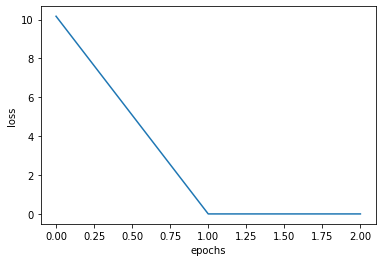

In [38]:
my_nn.plot_loss_history()

## optimizers tests

In [12]:
    #---------------------------------------------------------------------------
    ### tests for optimizers
    #---------------------------------------------------------------------------

    my_nn=handmade_nn(input_dim = 2)
    my_nn.add_dense_layer(1, 'linear',)
    X= np.ones((10_000, 2))
    y= np.zeros((10_000,1))
    my_nn.fit(X,y, loss='mse',optimizer_type='adam', batch_size=7, n_epochs=2)
    
    assert my_nn.score(X,y,'mse') < 0.5,\
        "not converged with adam optimizer on a trivial regression"
    
    my_nn.loss_history

initial loss: 1.235009060819703
final loss: 9.321500930834222e-30


[1.235009060819703, 7.841921513571235e-10, 9.321500930834222e-30]

# Trash section : small tests, to be deleted

In [39]:
for i in range(1):
    !touch file.py

In [41]:
a=2
mycode = 'print ("hello world",a)'
exec(mycode)

hello world 2


Benchmarking the optimization of the fit code

In [10]:
from sklearn.datasets import make_circles
adam_after_1000_classic_fit=[]
for i in range(10):
    X_circle, y_circle = make_circles(n_samples= 100, noise=0.05, factor=0.5,random_state=1)
    X_circle *= 0.8
    model = handmade_nn(input_dim=2)
    model.add_dense_layer(4,'relu')
    model.add_dense_layer(4,'relu')
    model.add_dense_layer(1, 'sigmoid')
    model.fit(X_circle,y_circle,loss='binary_crossentropy', optimizer_type= 'adam', batch_size=16,n_epochs=1000)
    adam_after_1000_classic_fit.append(model.loss_history[-1])

initial loss: 0.693759184303861
final loss: 0.002498051048979098
initial loss: 0.6870495146958491
final loss: 0.0012700289280416401
initial loss: 0.6813998166626699
final loss: 0.001054249886758239
initial loss: 0.6633454788289243
final loss: 0.0013288610676517
initial loss: 0.6887470529040961
final loss: 0.0011919493285844805
initial loss: 0.7272670766187274
final loss: 0.0013993113372537968
initial loss: 0.6863515242981754
final loss: 0.0006963239815838813
initial loss: 0.6781025629662788
final loss: 0.005431278789395259
initial loss: 0.6903762207278575
final loss: 0.01592412910593394
initial loss: 0.6922005917658645
final loss: 0.015246187878474036


In [11]:
from sklearn.datasets import make_circles
adam_after_1000_fit_with_precomputed_minibatches=[]
for i in range(10):
    X_circle, y_circle = make_circles(n_samples= 100, noise=0.05, factor=0.5,random_state=1)
    X_circle *= 0.8
    model = handmade_nn(input_dim=2)
    model.add_dense_layer(4,'relu')
    model.add_dense_layer(4,'relu')
    model.add_dense_layer(1, 'sigmoid')
    model.fit_with_precomputed_minibatches(X_circle,y_circle,loss='binary_crossentropy', optimizer_type= 'adam', batch_size=16,n_epochs=1000)
    adam_after_1000_fit_with_precomputed_minibatches.append(model.loss_history[-1])

initial loss: 0.6980376242324604
final loss: 0.004403383002847579
initial loss: 0.693166320000546
final loss: 0.0014675179879310655
initial loss: 0.6786645009071909
final loss: 0.0022207900991894946
initial loss: 0.7414364420311298
final loss: 0.6945858288904659
initial loss: 0.6977913398813678
final loss: 0.6945858274739996
initial loss: 0.6969300184942588
final loss: 0.017833226017322075
initial loss: 0.7134478462040089
final loss: 0.014525862240557075
initial loss: 0.6703194785422077
final loss: 0.0007807349312243983
initial loss: 0.7055730552018095
final loss: 0.012802260970151236
initial loss: 0.6955597022403449
final loss: 0.014611117625693655


In [14]:
from sklearn.linear_model import ElasticNet

In [4]:
(-0.45*5 + 0.674*2-0.116)

-1.018